In [266]:
import pandas as pd
import numpy as np
import networkx as nx
import itertools

In [267]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [268]:
from typing import Union, List, Tuple

# Index

This second notebook covers the following intermediate Graph Theory topics:

1. [Multigraphs](#Multigraphs)\
   1.1 [An applications of Multigraph in Social Network analysis](An-applications-of-Multigraph-in-Social-Network-analysis)
2. [Coloring Theory](Coloring-Theory)\
   2.1 [The Brooks Theorems](The-Brooks-Theorems)\
   2.2 [The chromatic polynomial](The-chromatic-polynomial)
3. [Graph Representations and the Adjacency Matrix](#Graph-Representations-and-the-Adjacency-Matrix)\
   3.1 [The spectrum of a graph](The-spectrum-of-a-graph)

In [269]:
def plot_multigraph(G: nx.MultiGraph(), type_curvature, figsize=(4, 4), **node_args):
    '''
    Function to visualize a NetWorkx Graph

    Args:
        G (nx.Graph): a Networkx Graph
        kwargs (optional keyword arguments): additional arguments to customize the visualization

    Returns:
        The graph visualization
    '''
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_title("Graph Visual", fontsize=12)

    pos = nx.spring_layout(G)
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, **node_args)
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight="bold")
    
    # Draw distinct edges with different curvature
    for (u, v, data) in G.edges(data=True):
        edge_type = data["type"]
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=2, alpha=0.7, 
            connectionstyle=f"arc3,rad={type_curvature[edge_type]}"
        )

    # Add edge labels
    edge_labels = {(u, v): d["type"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
    

    plt.show()

# Intermediate concepts in Graph Theory: from *Multigraphs* to *Bipartite Graphs*

In the first notebook, we covered the basics of Graph Theory, introducing concepts such as simple graphs and exploring fundamental theorems regarding their structure and topology. Additionally, we demonstrated how to work with simple graphs in Python using the `networkx` package. In this notebook, we will delve deeper into the subject by discussing more advanced topics, including *multigraphs* and the so-called coloring theory. Furthermore, we will explore different graph representations, such as *adjacency matrices*, which enable the application of important results from linear algebra to graphs. Finally, we will examine *bipartite graphs*, a special class of graphs that naturally arise in various fields, from social networks to solid-state physics.

## Multigraphs

**Definition**: Let $V$ be a set. Then we define $P_{1,2}(V)$ the set of all 1-element or 2-element subsets of $V$, i.e.:
$$
P_{1,2}(V) = \{ S \subseteq V | |S| = {1, 2} \}  = \{ \{ u, v\} | u, v \in V \} \ \text{not necessarily distinct}
$$
For example, $P_{1, 2}(1, 2, 3) = \{ \{1\}, \{2\}, \{3\}, \{1, 2\}, \{2, 3\}, \{1, 3\}\}$. 

**Definition**: A **multigraph** is defined as $G=(E, V, \varphi)$ a set of three elements: $E$ is the **edge set**, $V$ is the **vertices set** and $\varphi$ is a map defined as $\varphi: E \rightarrow P_{1,2}(V)$.

Roughly speaking, we may say that a *multigraph* is a graph where two vertices can be connected by more than one edge (distinct elements of $P_{1, 2}(V)$ of dimension 2) and one edge can connect a node with itself (elements of dimension 1 in $P_{1,2}(V)$. Let us show how to define a multigraph in `networkx`:

In [270]:
# using the MultiGraph class
G = nx.MultiGraph()

In [271]:
nodes = [1, 2, 3, 4]
edges = [(1, 2, "A"), (1, 1, "A"), (2, 3, "A"), (2, 3, "B"), (3, 4, "A")]

In [272]:
G.add_nodes_from(nodes)
G.add_edges_from((u, v, {"type": label}) for u, v, label in edges)

[0, 0, 0, 1, 0]

Notice that we have introduced an additional parameter when defining edges, namely `type`, which in the above example can be "A" or "B":

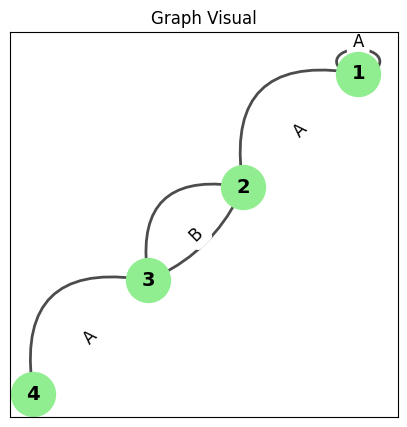

In [273]:
plot_multigraph(
    G, 
    type_curvature={"A": .7, "B": -0.2},
    figsize=(5,5),
    node_color="lightgreen",
    node_size=1000
)

All the definitions given for simple graphs still hold for multigraph. In particular, the **degree** $\deg(v)$ of a vertex $v \in V$ in a multigraph is the number of edges that contain $v$, where loops are counted twice:
$$
\deg v := | \{e \in E | v \in \varphi(e)\}| + | \{ e \in E | \varphi(E) = \{ v\} \}|
$$
Notice that, unlike for simple graphs, in multigraphs the degree of a node is not the number of **neigbors** of $v$, unless $v$ is not contained in any loops or in **parallel edges**. Parallel edges are two edges connecting the same nodes. For example, in the above graphs:

In [274]:
# The degree of 1 is 3: 1 loop plus a single edge
G.degree(1)

3

In [275]:
len(list(G.neighbors(1)))

2

Also the notions of **walks** and **paths** can be still applied to multigraph. Let us introduce a special class of paths that we missed in the first notebook, namely

**Definition**: Let $G=(V, E)$ a simple graph. An **Hamiltonian path** in $G$ is a walk of $G$ that contains each vertex of $G$ exactly once, i.e. it is a path.

**Defintion**: Let $G=(V, E)$ a simple graph. An **Hamiltonian cycle** in $G$ is a cycle $(v_0, v_1, ..., v_{k})$ of $G$ such that each vertex of $G$ appears exactly once among $v_0, v_1, ..., v_{k-1}$.

These definitions apply as well for multigraphs. Of course, not all graphs have Hamiltonian paths. However, if a graph has an Hamiltonian cycle then it as an Hamiltonian path, obtained by removing the last vertex. Finding an Hamiltonian path or an Hamiltonian cycle or prove that none exists is known as the **"Hamiltonian path problem**. It is an hard known problem in the computer science literature because it is an NP-hard problem: it can be solved with a brute-force approach but no polynomial-time algorithms are known. Some fastest algorithms exist but the best are at most with a complexity of $O(n^22^n)$. Below, an example of a graph with an Hamiltonian path:

In [276]:
G_hamp = nx.MultiGraph()

hamp_nodes = [1, 2, 3, 4, 5]
hamp_edges = [(1, 2, "A"), (2, 3, "A"), (3, 4, "A"), (4, 5, "A"), (5, 1, "B"), (2, 4, "C"), (2, 3, "B")]

G_hamp.add_nodes_from(nodes)
G_hamp.add_edges_from((u, v, {"type": label}) for u, v, label in hamp_edges)

[0, 0, 0, 0, 0, 0, 1]

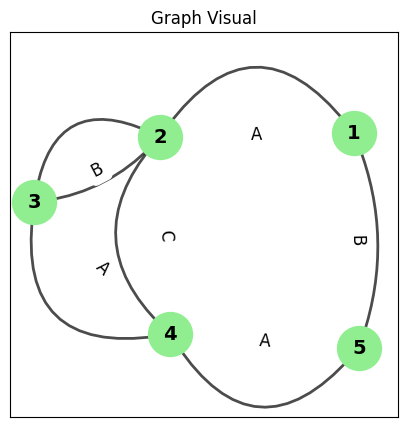

In [277]:
plot_multigraph(
    G_hamp, 
    type_curvature={"A": .7, "B": -0.2, "C": 0.5},
    figsize=(5,5),
    node_color="lightgreen",
    node_size=1000
)

The Hamiltonian path in the above example is the path defined by the vertices: $ 1 \rightarrow 2 \rightarrow 3 \rightarrow 4 \rightarrow 5$.

In part 1, we have discussed and proved one of the most important theorem in graph theory, the **Euler's theorem**. Such theorem can be stated as well for multigraphs:

**Theorem (Euler, 1736)**: Let $G=(V, E, \varphi)$ be a multigraph. Then:
$$
\sum_{v \in V(G)} \deg(v) = 2\cdot |E(G)|
$$
*Proof.* For each edge $e$, let us denote $\alpha(e)$ and $\beta(e)$ its endpoints. If $e$ is a loop, then $\alpha(e)=\beta(e)$. By definition of degree for multigraphs we have
$$
\deg(v) = \sum_{e \in E | v = \alpha(e)} 1 + \sum_{e \in E | v = \beta(e)}1
$$
notice that for a loop, the edge is counted twice, because $v$ is both $\alpha(e)$ and $\beta(e)$. Summing over all v:
$$
\begin{align}
\deg(v) &= \sum_{v\in V} \sum_{e \in E | v = \alpha(e)} 1 + \sum_{v\in V}\sum_{e \in E | v = \beta(e)} 1 \\
&= |E|+|E| = 2 |E|
\end{align}
$$
Indeed, if for each $v$ we sum the number of edges, we simply get the total number of edges. Therefore the theorem is proved. 

The definition of **graph isomorphism** is instead different for multigraphs, and a single bijective map between vertex of two graphs is not sufficient to define whether they are isomorphic or not. 

**Definition**: Let $G=(V, E, \varphi)$ and $H=(W, F, \psi)$ be two multigraphs. A **graph isomorphism** between $G$ and $H$ is a pair of bijective relations $(\phi_1, \phi_2)$:
$$
\begin{gather}
\phi_1: V \rightarrow W \\
\phi_2: E \rightarrow F
\end{gather}
$$
such that if $e \in E$, with endpoints $(v_1, v_2)$, then the endpoints of $\phi_2(e)$, say $w_1, w_2$, are the images under $\phi_1$ of the endpoints of $e$, i.e. $\phi_1(v_1) = w_1$.

### An applications of Multigraph in Social Network analysis

As you may have understood, multigraphs can be used in many real-life scenarios where relationships between entities are not straightforward and can be of multiple type. A common example is that of **social networks**, where edges can be used to represent "interactions" between persons and thus a multigraph can capture the variety of interactions that social network enables. Let us make a practical example, considering the following multigraph:

In [278]:
G_sn = nx.MultiGraph()

In [279]:
person_nodes = ["Alice", "Bob", "Hilbert", "Laplace", "Marie"]
interaction_edges = [("Alice", "Bob", 5, "DM"), 
                     ("Alice", "Bob", 2, "Comment"),
                     ("Bob", "Hilbert", 3, "DM"),
                     ("Hilbert", "Marie", 6, "Comment"),
                     ("Laplace", "Marie", 4, "Comment")
                    ]

In [280]:
G_sn.add_nodes_from(person_nodes)
G_sn.add_edges_from((u, v, weight, {"type": label, "weight": weight}) for u, v, weight, label in interaction_edges)

[5, 2, 3, 6, 4]

We have a mutligraph representing a social network where people can interact in two ways: via "DM", i.e. *direct messages*, or with "Comment", i.e. *leaving* comment on friend's post. The multigraph is also "weighted" in the sense that we have assigned a number to each edge, indicating the number of direct messages or the number of commens. Let's visualize the multigraph (we are using a drawing function provided by the `NetworkX` docs: look at the following link [Plotting Multigraph](https://networkx.org/documentation/stable/auto_examples/drawing/plot_multigraphs.html))

In [281]:
def draw_labeled_multigraph(G, attr_name, weight_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in itertools.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="lightblue", ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attrs[attr_name]}|{weight_name}={attrs[weight_name]}"
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.5,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )

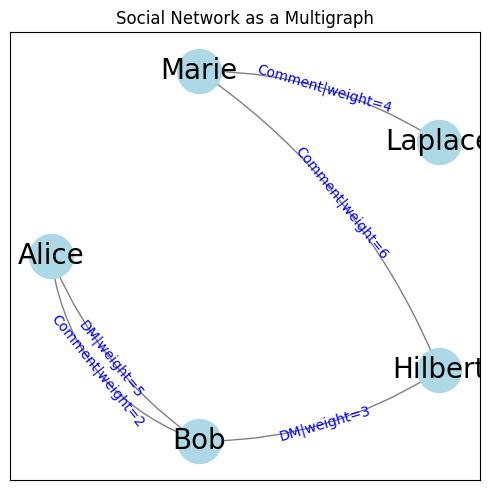

In [282]:
fig, ax = plt.subplots(figsize=(5, 5))
draw_labeled_multigraph(G_sn, "type", "weight", ax)
ax.set_title("Social Network as a Multigraph")
fig.tight_layout()
plt.show()

Some analysis we could perform on such a graph may be:
- *finding the strongest communication channels*;
- *identifying persons mostly interacting with each other*

For example:

In [283]:
# Identifying persons with the highest interactions
sum_person_nteractions = {}
for person in G_sn.nodes():
    sum_person_nteractions[person] = sum(data["weight"] for i, v, data in G_sn.edges(data=True) if person in (i, v))

In [284]:
sum_person_nteractions

{'Alice': 7, 'Bob': 10, 'Hilbert': 9, 'Laplace': 4, 'Marie': 10}

In the above example, Bob has the highest interaction score (considered as the sum of interaction weights). As for the most used communication channels:

In [285]:
sum_interactions = {"DM": 0, "Comment": 0}
for u, v, data in G_sn.edges(data=True):
    type = data["type"]
    sum_interactions[type] += data["weight"]

In [286]:
sum_interactions

{'DM': 8, 'Comment': 12}

The "Comment" communication channel has insted the highest summed weights. 

Since we are talking about social network theory, let us now prove an interesting result in graph theory which leads to a curious features of social networks. Let $G=(V, E, \varphi)$ a multigraph with no loop and let $e \in E$ an edge of $G$. Let us assume that $v$ is an endpoint of $e$ and we denote as $e/v$ the endpoint of $e$ distinct from $v$. For each $v$ we define the following rational number $q_v$:
$$
q_v = \sum_{e \in E, v \in \varphi(E)} \frac{\deg(e/v)}{\deg(v)}
$$
Thus, $q_v$ is the *average degree of the neighbors of $v$*, weighted by the number of edges that join $v$ to its neighbors. We can prove that

<div style="text-align: center; border: 2px solid black; background-color: #D3D3D3; padding: 10px; display: inline-block; margin: auto;">
\[
\sum_{v\in V} q_v \geq \sum_{v \in V} \deg(v)
\]
</div>

In other words, *your average friend in a social network has, on average, more friends than you do!*. From the Euler's theorem, the above result can be restated as:
$$
\sum_{v\in V} q_v \geq 2|E|
$$
Summing over $v$ the expression of $q_v$ we get:
$$
\sum_v \sum_{e \in E, v \in \varphi(E)} \frac{\deg(e/v)}{\deg(v)} =  |E| \left( \frac{\deg(e/v)}{\deg(v)} + \frac{\deg(v)}{\deg(e/v} \right)
$$
Indeed, when summing over all nodes, for each edge, each endpoint will be once the first node and then the neighbor, thus the double sum is equivalent to multiply the expression in parenthesis by the number of edges in the graph. Now, consisder the following expression:
$$
(x-y)^2 \geq 0
$$
which is positive for any real positive number $x, y > 0 $. Therefore, 
$$
(x-y)^2 = x^2+y^2 - 2xy \geq 0 \Longrightarrow x^2+y^2 \geq 2xy
$$
Dividing by $xy$ both side (since $xy>0$):
$$
\frac{x^2}{xy}+\frac{y^2}{xy} = \frac{x}{y} + \frac{y}{x} \geq 2
$$
In the equation for $q_v$ we can recognize the expression given by the above inequality, therefore we by substitution:
$$
\sum_{v\in V} q_v = |E| \left( \frac{\deg(e/v)}{\deg(v)} + \frac{\deg(v)}{\deg(e/v} \right) \geq |E|\cdot 2 
$$

## References

- *An introduction to graph theory*, DarijGrinberg, arXiv:2308.04512v2 (2024)
- [*NetworkX Tutorial*](https://networkx.org/documentation/stable/tutorial.html)